<a href="https://colab.research.google.com/github/krishnapatury/DataScience/blob/main/DeepLearning_SVHN_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Street View Housing Number Digit Recognition**

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The Street View Housing Numbers (SVHN), a popular image recognition, dataset contains over 600,000 labeled digits cropped from street-level photos. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents. 


## **Objective**
To build an artificial feed-forward neural network model and a convolutional neural network that can recognize the digits in the images. 

## **Dataset**
Used a subset of the original data provided as a .h5 file to save some computation time. The basic preprocessing steps have been applied on the dataset.

## **Mounting the Google drive**

Due to higher RAM needs for Deep Learning models, I chose to use Google colab instead of Jupyter.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the necessary libraries**

In [2]:
# Library to handle .h5 file formats
import h5py

# Library for performing numerical computations
import numpy as np

# Library for visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical

import random

**Version of tensorflow.**

In [3]:
print(tf.__version__)

2.11.0


## **Loading the dataset available as a .h5 file**


In [4]:
# Open the file as read only
h5f = h5py.File('/content/drive/MyDrive/ADSP/DeepLearning/SVHN_single_grey1.h5', 'r')

# Load the training dataset
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]

# Load the test dataset
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

# Close this file
h5f.close()

print("Number of images in training set:" , len(X_train))
print("Number of images in test set:" , len(X_test))

Number of images in training set: 42000
Number of images in test set: 18000


##Custom Methods##

In [5]:
# Method to clear out previous model's history and fix random seeds to get same results for each run
def soft_reset():

  # Clear the previous model's history from the Keras backend.
  backend.clear_session()

  # Fixing the seed for random number generators
  np.random.seed(42)
  random.seed(42)
  tf.random.set_seed(42)


# Method for plotting the validation and training accuracies
def accuracyplot(model_hist, nepochs):

  dict_hist = model_hist.history

  list_ep = [i for i in range(1, nepochs+1)]

  plt.figure(figsize = (8, 8))
  plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
  plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()


# Method to generate a classification report and plot the heatmap using confusion matrix
def print_metrics(y_test, test_pred):

  # Each entry of the target variable is a one-hot encoded vector. 
  # To print the classification report and confusion matrix, convert each entry of y_test to a single label.
  predicted_value = np.argmax(test_pred, axis = -1)
  actual_value = np.argmax(y_test, axis = -1)

  print(actual_value, predicted_value)

  # Printing the classification report
  print(classification_report(actual_value, predicted_value))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(actual_value, predicted_value)     
  plt.figure(figsize = (8, 5))
  sns.heatmap(cm, annot = True,  fmt = '.0f')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()


## **Visualizing the first 10 images and labels**

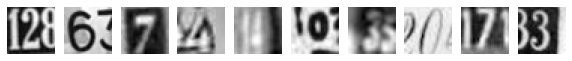

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [6]:
# Visualizing the first 10 images in the dataset and printing their labels
plt.figure(figsize = (10, 1))

for i in range(10):

    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap = "gray")
    plt.axis('off')

plt.show()

print('label for each of the above image: %s' % (y_train[0:10]))

## **Data preparation**

In [7]:
# Print the shape and the array of pixels for the first image in the training dataset.
print("Shape:", X_train[0].shape)
print()
print("First image:\n", X_train[0])

Shape: (32, 32)

First image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


## Preprocess the data before building the model ##

In [8]:
# Reshaping the dataset to flatten the 2D image into 1D array
X_train = X_train.reshape(X_train.shape[0], 1024)
X_test = X_test.reshape(X_test.shape[0], 1024)

# New shape 
print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

# Normalized inputs from 0-255 to 0-1
X_train = X_train.astype(float)/255.0
X_test = X_test.astype(float)/255.0

# One-hot encoded output
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Test labels
print('Test labels:',y_test)

Training set: (42000, 1024) (42000,)
Test set: (18000, 1024) (18000,)
Test labels: [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]


## **Model Building**

Build an ANN model. Setting the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow, to reproduce the same results every time I run the code.

In [9]:
# Clear previous model's history from Keras backend and fixes the seed for random number generators
soft_reset()

### **ANN Model Architecture**
- Sequential model with  2 hidden layers and and an output layer using a softmax for the output layer and relu as the imput layer activation functions.
- Compiling the model with the a categorical_crossentropy loss, an Adam optimizer with a learning rate of 0.001), and using accuracy for the performance metric. 
- Fit on the train data with a validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20. 

In [10]:
# Define the model
def ann_model_1():

    # Layers will be added sequentially
    model = Sequential() 
    
    model.add(Dense(64, activation = 'relu', input_shape = (1024, )))
    model.add(Dense(32, activation = 'relu'))

    model.add(Dense(10, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
    
    return model

# Build the model
ann_model1 = ann_model_1()

# Print the summary
ann_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65600     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 68,010
Trainable params: 68,010
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Fit on the train data with a validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20
# Store the model building history to use later for visualization.
history_ann_model_1 = ann_model1.fit(X_train, y_train, validation_split = 0.2, batch_size = 128, verbose = 1, epochs = 20)

Epoch 1/20
263/263 [==============================] - 5s 5ms/step - loss: 2.2966 - accuracy: 0.1149 - val_loss: 2.2563 - val_accuracy: 0.1470
Epoch 2/20
263/263 [==============================] - 1s 4ms/step - loss: 2.1074 - accuracy: 0.2301 - val_loss: 1.9578 - val_accuracy: 0.3214
Epoch 3/20
263/263 [==============================] - 1s 4ms/step - loss: 1.8571 - accuracy: 0.3564 - val_loss: 1.7346 - val_accuracy: 0.4093
Epoch 4/20
263/263 [==============================] - 1s 4ms/step - loss: 1.6566 - accuracy: 0.4415 - val_loss: 1.5700 - val_accuracy: 0.4821
Epoch 5/20
263/263 [==============================] - 1s 5ms/step - loss: 1.5184 - accuracy: 0.4946 - val_loss: 1.4966 - val_accuracy: 0.4975
Epoch 6/20
263/263 [==============================] - 1s 5ms/step - loss: 1.4423 - accuracy: 0.5219 - val_loss: 1.3999 - val_accuracy: 0.5406
Epoch 7/20
263/263 [==============================] - 2s 6ms/step - loss: 1.3963 - accuracy: 0.5404 - val_loss: 1.3722 - val_accuracy: 0.5531
Epoch 

#### **Plotting the validation and training accuracies**

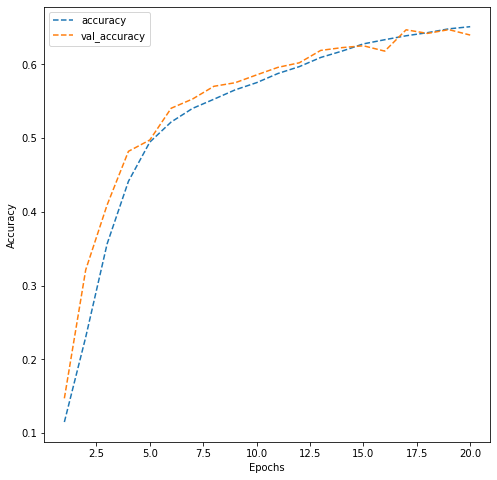

In [12]:
accuracyplot(history_ann_model_1, 20)

**Observations:

The model is performing similarly on the training and validation/test data which implies it has generalized well. The accuracy is improving as the number of epochs increases even at 20. Accuracy is 69.25% for training and 69.04% for validation data at the end of 20 epochs. The number of epochs can be increased in the next model in addition to adding more layers and increasing complexity to improve performance.

Will build a second model with higher complexity to improve the performance.



### **ANN Second Model**
- Sequential model with 5 hidden layers and an output layer with Batch Normalization and drop out layer added to prevent overfitting. 
- Compile the model with an even smaller learning rate of 0.0005.
- Fit on the train data with a validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30.

In [13]:
# Define the model
def ann_model_2():

    model = Sequential()  
    
    # First hidden layer with 256 nodes and the relu activation and the input shape = (1024, )
    model.add(Dense(256, activation = 'relu', input_shape = (1024, )))
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.2))

    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))

    model.add(BatchNormalization())

    # Output layer with activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10
    model.add(Dense(10, activation = 'softmax'))

    # Compile the model categorical_crossentropy loss, Adam optimizer with learning_rate = 0.0005
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])

    return model

# Clear previous model's history from Keras backend and fixes the seed for random number generators
soft_reset()

# Build the model
ann_model_2 = ann_model_2()

# Print the model summary
ann_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               1

In [14]:
# Fit on the train data with 30 epochs
history_ann_model_2 = ann_model_2.fit(X_train, y_train, validation_split = 0.2, batch_size = 128, verbose = 1, epochs = 30)

Epoch 1/30
263/263 [==============================] - 2s 7ms/step - loss: 2.3268 - accuracy: 0.0988 - val_loss: 2.3014 - val_accuracy: 0.0955
Epoch 2/30
263/263 [==============================] - 1s 5ms/step - loss: 2.2352 - accuracy: 0.1416 - val_loss: 2.1524 - val_accuracy: 0.2055
Epoch 3/30
263/263 [==============================] - 1s 5ms/step - loss: 1.8422 - accuracy: 0.3295 - val_loss: 1.7476 - val_accuracy: 0.4546
Epoch 4/30
263/263 [==============================] - 1s 5ms/step - loss: 1.4751 - accuracy: 0.5029 - val_loss: 1.3038 - val_accuracy: 0.5719
Epoch 5/30
263/263 [==============================] - 2s 6ms/step - loss: 1.2988 - accuracy: 0.5735 - val_loss: 1.2294 - val_accuracy: 0.5890
Epoch 6/30
263/263 [==============================] - 2s 7ms/step - loss: 1.1930 - accuracy: 0.6117 - val_loss: 1.1445 - val_accuracy: 0.6314
Epoch 7/30
263/263 [==============================] - 1s 5ms/step - loss: 1.1288 - accuracy: 0.6392 - val_loss: 1.0679 - val_accuracy: 0.6610
Epoch 

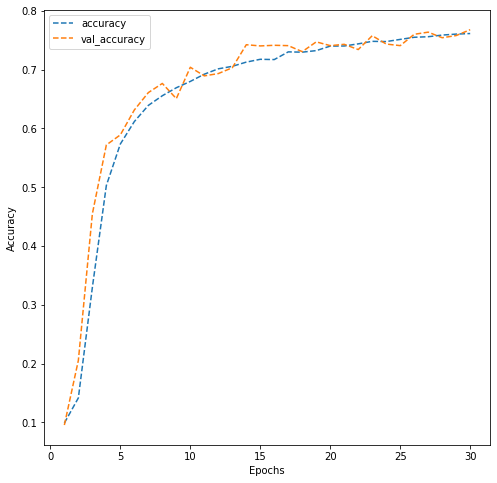

In [15]:
# Plotting the accuracies
accuracyplot(history_ann_model_2, 30)

**Observations:

Increasing the complexity and number of epochs has improved accuracy of the model and has continued to perform well on the validation data implying good generalization. At the end of 30 epochs the model accurary on training data is 77.11% and 76.39% on the test validation data. The loss has also decreased a lot from over 1 in the previous model to .77 and 0.76 on the training and validation data. Due to consistency in the performance between the 2 datas we can conclude that the model has learned well and is not overfitting the data.

#### **Predictions on the test data** 


In [16]:
# Make predictions on the test set using the second model.
test_pred = ann_model_2.predict(X_test)

563/563 [==============================] - 1s 2ms/step


#### **Performance Metrics**
Generated a classification report and plotted the heatmap using confusion matrix

[1 7 2 ... 7 9 2] [2 2 2 ... 7 9 2]
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      1814
           1       0.76      0.78      0.77      1828
           2       0.75      0.79      0.77      1803
           3       0.75      0.71      0.73      1719
           4       0.74      0.85      0.79      1812
           5       0.74      0.75      0.74      1768
           6       0.79      0.76      0.77      1832
           7       0.75      0.81      0.78      1808
           8       0.77      0.70      0.74      1812
           9       0.75      0.74      0.74      1804

    accuracy                           0.76     18000
   macro avg       0.77      0.76      0.76     18000
weighted avg       0.77      0.76      0.76     18000



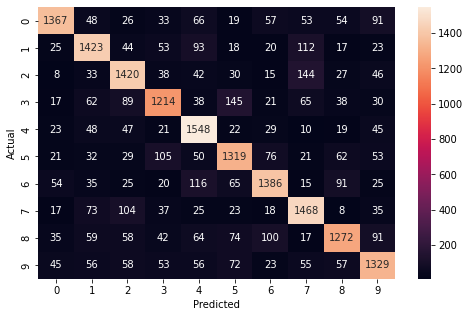

In [17]:
# Printing the classification report and plot the heatmap using confusion matrix
print_metrics(y_test, test_pred)

**Final Observations:

The model has classified most digits correctly although there are several misclassifications. There is some confusion between digits 1 and 7 which is understandable. 5 and 3, and 4 and 1 also have more than a 100 misclassifications. There are several combinations like 5-0, 2-0, 4-7, 7-8 etc where there are very few misclassfications. Overall the model has been to classify the digits successfully with an accuracy of 76% which shows room for improvement. One could try to add more layers to further reduce the misclassification as the accuracy overall consistently increased as the number of epochs increased. A CNN model could be built by adding convolution and pooling layers to improve feature learning and overall performance. 

### **CNN Model Architecture**

Added a few convolutions for better feature learning and used LeakyRelu for activation functions. 

In [18]:
# Reshaping the dataset to a 4D array to be able to pass as input to Convolution layer. 
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

# New shape 
print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)
y_train

Training set: (42000, 32, 32, 1) (42000, 10)
Test set: (18000, 32, 32, 1) (18000, 10)


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
# Define the model
def cnn_model_1():

    model = Sequential() 

    # First Convolutional layer with 16 filters and the kernel size of 3x3. Use the 'same' padding and provide the input shape = (32, 32, 1)
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", input_shape = (32, 32, 1)))
    # Add a LeakyRelu layer with the slope equal to 0.1
    model.add(LeakyReLU(0.1))

    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same"))
    model.add(LeakyReLU(0.1))

    model.add(MaxPool2D(pool_size = (2, 2)))

    # Flatten the output from the previous layer
    model.add(Flatten())

    model.add(Dense(32))
    model.add(LeakyReLU(0.1))
    model.add(Dense(10, activation = 'softmax'))

    # Compile the model with the categorical_crossentropy loss, an Adam optimizer with learning_rate = 0.001
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
    
    return model

## Clear previous model's history from Keras backend and fixes the seed for random number generators
soft_reset()

# Build the model
cnn_model_1 = cnn_model_1()

# Print the model summary
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                        

In [20]:
# Fit the model on the training data with a validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20. 
history_cnn_model_1 = cnn_model_1.fit(X_train, y_train, validation_split = 0.2, batch_size = 32, verbose = 1, epochs = 20)

Epoch 1/20
1050/1050 [==============================] - 12s 5ms/step - loss: 1.1128 - accuracy: 0.6399 - val_loss: 0.6391 - val_accuracy: 0.8151
Epoch 2/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.5442 - accuracy: 0.8444 - val_loss: 0.5228 - val_accuracy: 0.8492
Epoch 3/20
1050/1050 [==============================] - 5s 4ms/step - loss: 0.4518 - accuracy: 0.8662 - val_loss: 0.5117 - val_accuracy: 0.8520
Epoch 4/20
1050/1050 [==============================] - 5s 5ms/step - loss: 0.3887 - accuracy: 0.8855 - val_loss: 0.4506 - val_accuracy: 0.8717
Epoch 5/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.3408 - accuracy: 0.8963 - val_loss: 0.4585 - val_accuracy: 0.8675
Epoch 6/20
1050/1050 [==============================] - 5s 5ms/step - loss: 0.3020 - accuracy: 0.9084 - val_loss: 0.4687 - val_accuracy: 0.8714
Epoch 7/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.2706 - accuracy: 0.9199 - val_loss: 0.4633 - val_accuracy

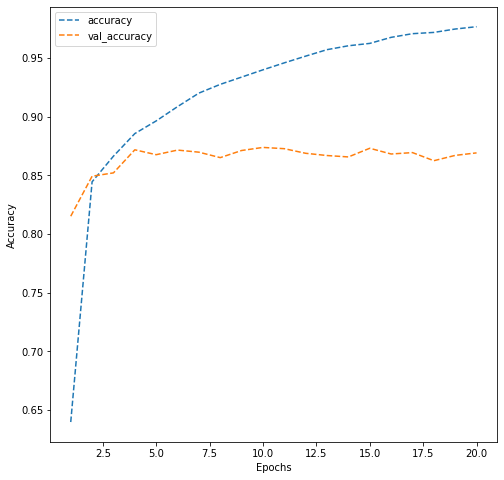

In [21]:
# Plotting the accuracies
accuracyplot(history_cnn_model_1, 20)

**Observations:

The model seems to have overfitted the training data as after a couple of epochs the accuracy on the validation/test data is not increasing and is stagnant at about 86%. The validation loss also increased after the 3rd epoch. The accuracy on the training data however is 97% at the end of 20 epochs with a constant increase in accuracy and decrease in loss. We can use Batch Normalization and Dropouts to reduce the overfitting for a better model. 

Built a second CNN model get more generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

### **CNN Second Model**

Sequential model with first Convolutional layer with 16 filters and the kernel size of 3x3. Added LeakyRelu layers with the slope of 0.1, and more convultion layers with MaxPooling and Batch normalization to address overfitting.

In [22]:
# Define the model
def cnn_model_2():
    
    model = Sequential()
    
    # First Convolutional layer with 16 filters and the kernel size of 3x3. Use the 'same' padding and provide the input shape = (32, 32, 1)
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", input_shape = (32, 32, 1)))
    model.add(LeakyReLU(0.1))

    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPool2D(pool_size = (2, 2)))

    model.add(BatchNormalization())

    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same"))
    model.add(LeakyReLU(0.1))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same"))
    model.add(LeakyReLU(0.1))

    model.add(MaxPool2D(pool_size = (2, 2)))

    model.add(BatchNormalization())

    # Flatten the output from the previous layer
    model.add(Flatten())

    model.add(Dense(32))
    model.add(LeakyReLU(0.1))

    model.add(Dropout(0.5))

    # Add the final output layer with nodes equal to the number of classes, i.e., 10 and 'softmax' as the activation function
    model.add(Dense(10, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
    
    return model

## Clear previous model's history from Keras backend and fixes the seed for random number generators
soft_reset()

# Build the model
cnn_model_2 = cnn_model_2()

cnn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                          

In [23]:
# Fit the model on the train data with epochs = 30. 
history_cnn_model_2 = cnn_model_2.fit(X_train, y_train, validation_split = 0.2, batch_size = 128, verbose = 1, epochs = 30)

Epoch 1/30
263/263 [==============================] - 4s 13ms/step - loss: 1.3286 - accuracy: 0.5467 - val_loss: 2.2302 - val_accuracy: 0.1776
Epoch 2/30
263/263 [==============================] - 3s 10ms/step - loss: 0.6646 - accuracy: 0.7968 - val_loss: 0.5288 - val_accuracy: 0.8556
Epoch 3/30
263/263 [==============================] - 3s 12ms/step - loss: 0.5452 - accuracy: 0.8336 - val_loss: 0.4483 - val_accuracy: 0.8700
Epoch 4/30
263/263 [==============================] - 3s 10ms/step - loss: 0.4909 - accuracy: 0.8490 - val_loss: 0.4026 - val_accuracy: 0.8848
Epoch 5/30
263/263 [==============================] - 3s 10ms/step - loss: 0.4381 - accuracy: 0.8626 - val_loss: 0.3656 - val_accuracy: 0.8982
Epoch 6/30
263/263 [==============================] - 3s 10ms/step - loss: 0.3987 - accuracy: 0.8772 - val_loss: 0.3714 - val_accuracy: 0.8950
Epoch 7/30
263/263 [==============================] - 3s 10ms/step - loss: 0.3766 - accuracy: 0.8846 - val_loss: 0.3678 - val_accuracy: 0.8969

#### **Validation and training accuracies plots**

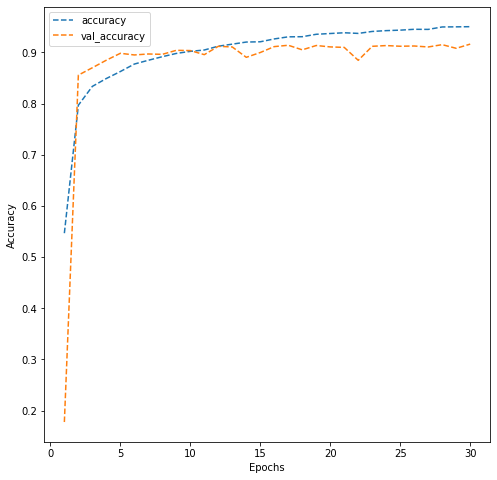

In [24]:
# Plotting the accuracies
accuracyplot(history_cnn_model_2, 30)

**Observations:
The model has generalized well with a contstant increase in accuracy and decrease in loss on both the training and testing data. At the end of 30 epochs the accuracies on the training and testing data are 94.85% and 91.15%. While there is a slight difference, the validation accuracy has improved significantly from the previous model and the overfitting issues seem to have been resolved in this model. 


#### **Predictions on the test data** 

In [25]:
# Make prediction on the test data using cnn_model_2 
test_pred = cnn_model_2.predict(X_test)

563/563 [==============================] - 1s 2ms/step


#### **Performance Metrics**
Generated a classification report and plotted the heatmap using confusion matrix

[1 7 2 ... 7 9 2] [1 7 2 ... 7 3 2]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1814
           1       0.91      0.92      0.91      1828
           2       0.93      0.93      0.93      1803
           3       0.89      0.91      0.90      1719
           4       0.94      0.93      0.93      1812
           5       0.91      0.92      0.91      1768
           6       0.91      0.90      0.90      1832
           7       0.93      0.95      0.94      1808
           8       0.94      0.87      0.90      1812
           9       0.91      0.91      0.91      1804

    accuracy                           0.92     18000
   macro avg       0.92      0.92      0.92     18000
weighted avg       0.92      0.92      0.92     18000



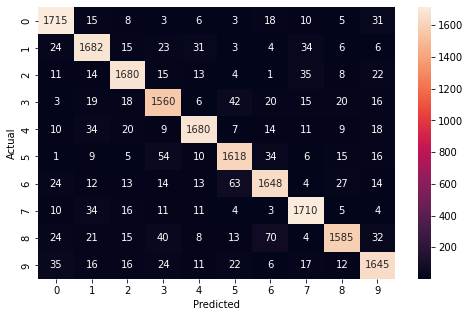

In [26]:
# Printing the classification report and plot the heatmap using confusion matrix
print_metrics(y_test, test_pred)

**Final Observations:

The second CNN model performed well with an accuracy of 91% which is a significant improvement from the ANN model. The misclassifications between some digit combinations like 5 and 3, 4 ansd 1 etc from the ANN model seemed to have reduced significantly. While there are several misclassifications even in this model (5 and 3 still have 55 misclassifications and there is still some confusion between 6 and 8), overall all the digits have an F1 score higher than 0.9. Since the accuracies on the training and testing data are close and over 90% we can consider to the model to be generalized and can expect it to perform well on unseen data. We can try hyperparameter tuning for some of the hyperparameters like the number of convolutional blocks, the number of filters in each Conv2D layer, filter size, activation function, adding/removing dropout layers, etc. Data Augmentation might help to make the model more robust and invariant toward different orientations.